# Final project -- milestone 4

Contributor: Martin Jin, Qimei Lin, Yingxue Lu, Yuhan Zhang

Due Date: 12/11/2019

In [2]:
# import the necessary libraries
import pandas as pd
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
# ! pip install pandas-datareader
import pandas_datareader.data as web
import datetime
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
sns.set(style="whitegrid")

## Import and Process Tweet data

1. Import Dataset from 'data/trump-tweets-11-18-2019.csv'

2. Change the data type of created_at to datetime.date

3. Restrict the dataset to original tweet only

4. Group by created_at to aggregate all tweets in a day to a single datum point.

5. Sort the Tweet data with a descending date order 

In [3]:
df_tweets = pd.read_csv('data/trump-tweets-11-18-2019.csv')
df_tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,https://t.co/Mqj5tXaDAz,11-18-2019 04:38:28,15115,41938,False,1196286528546332672
1,Twitter for iPhone,“All they do is bring up witnesses who didn’t ...,11-18-2019 03:39:38,16476,61998,False,1196271720392511489
2,Twitter for iPhone,“The Impeachment started before he even became...,11-18-2019 02:40:04,18488,75282,False,1196256729471827968
3,Twitter for iPhone,https://t.co/1Rg66Tn4uP,11-17-2019 22:57:43,16318,51690,False,1196200775560634368
4,Twitter for iPhone,https://t.co/D66PEkuX6d,11-17-2019 22:51:37,12209,38663,False,1196199239715639302


In [4]:
#get the tweet data from downloaded data
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at']).dt.date
df_tweets['trump_tweet_cnt'] =[1 if reFlag ==False else 0 for reFlag in df_tweets['is_retweet'].values]
df_tweets['trump_retweet_cnt'] =[0 if  reFlag ==False else 1 for reFlag in df_tweets['is_retweet'].values]
df_tweets_cleaned = df_tweets.groupby('created_at', as_index = False).agg({
    'trump_tweet_cnt': 'sum',
    'trump_retweet_cnt': 'sum',
    'retweet_count': 'sum',
    'favorite_count': 'sum',
    'text':'sum'
})

df_tweets_cleaned= df_tweets_cleaned.sort_values('created_at',ascending=False)
df_tweets_cleaned.head()

,created_at,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count,text
1018,2019-11-18,3,0,50079,179218,https://t.co/Mqj5tXaDAz“All they do is bring u...
1017,2019-11-17,36,15,666343,1668991,https://t.co/1Rg66Tn4uPhttps://t.co/D66PEkuX6d...
1016,2019-11-16,14,11,414895,932464,Louisiana 3 hours left get out and Vote for @E...
1015,2019-11-15,19,24,733886,1313131,https://t.co/8h6ZmdGlPf https://t.co/shaijXMXl...
1014,2019-11-14,13,21,444871,988437,....We send our deepest condolences to the fam...


### Import lexicon polarity data. The polarity file was adopted from vader Sentiment: https://github.com/cjhutto/vaderSentiment.git

In [9]:
sent = pd.read_csv('data/vader_lexicon.txt', sep='\t', header=None)
sent = sent.drop([2, 3], 1)
sent.index.rename('token', inplace=True)
sent.rename(columns={1: 'polarity'}, inplace=True)
sent.head()

,0,polarity
token,,
0,$:,-1.5
1,%),-0.4
2,%-),-1.5
3,&-:,-0.4
4,&:,-0.7


### The following section puts polarity and tag information into Trump's sweet data set

In [11]:
trump_tweets = pd.read_csv('data/trump-tweet-in-office.csv')
trump_tweets['created_at'] =  pd.to_datetime(trump_tweets['created_at']).dt.date

trump = trump_tweets.copy()
trump['id']=trump['id_str']
trump = trump.set_index(['id'])

repl_punc = trump['text'].str.replace(r"[?|,|$|!|&|.|#|^|;|:|/|\"]", ' ')
replacequotes = repl_punc.str.replace(r'^"', '')

# Save your regex in punct_re
punct_re = r"[^\w\s]"
#[?|,|$|!|&|.|#|^|;|:|/|\"]
trump['no_punc'] = trump['text'].str.replace(punct_re, " ")

In [12]:
trumpcopy = trump.copy()
changed_punc = trumpcopy['no_punc'].str.replace('\s+', ' ')
trumpcopy['no_punc'] = changed_punc
splt = trumpcopy['no_punc'].str.split(expand=True).stack().reset_index().set_index('id')
splt.columns = ['num', 'word']

In [13]:
splt.head(10)


,num,word
id,,
1187551862616141824,0,RT
1187551862616141824,1,RepLeeZeldin
1187551862616141824,2,This
1187551862616141824,3,impeachment
1187551862616141824,4,inquiry
1187551862616141824,5,has
1187551862616141824,6,produced
1187551862616141824,7,NOTHING
1187551862616141824,8,to


In [15]:
tidy_format = splt
newt = tidy_format.reset_index()
newsent = sent.reset_index().rename(columns = {'token': 'word'})
display(newt.head())
display(newsent.head())

,id,num,word
0,1187551862616141824,0,RT
1,1187551862616141824,1,RepLeeZeldin
2,1187551862616141824,2,This
3,1187551862616141824,3,impeachment
4,1187551862616141824,4,inquiry


,word,0,polarity
0,0,$:,-1.5
1,1,%),-0.4
2,2,%-),-1.5
3,3,&-:,-0.4
4,4,&:,-0.7


In [16]:
newt = tidy_format.reset_index()
#newt = newt.drop('num')
newt1 = newt[['id', 'word']].copy()
newsent = sent.reset_index().rename(columns = {0: 'word'})
newsent1 =newsent[['polarity', 'word']].copy()
display(newt1.head())
display(newsent1.head(10))

,id,word
0,1187551862616141824,RT
1,1187551862616141824,RepLeeZeldin
2,1187551862616141824,This
3,1187551862616141824,impeachment
4,1187551862616141824,inquiry


,polarity,word
0,-1.5,$:
1,-0.4,%)
2,-1.5,%-)
3,-0.4,&-:
4,-0.7,&:
5,1.6,( '}{' )
6,-0.9,(%
7,2.2,('-:
8,2.3,(':
9,2.1,((-:


In [17]:
polar = pd.merge(newt1, newsent1, how='outer', on= 'word')
newpol = polar.groupby('id').sum()
###newpol = newpol.drop('num', 1).fillna(0)
newpol = newpol.fillna(0)

In [18]:
polarities = newpol
maybpol = polarities.reset_index()
maybtrump = trump.reset_index()

In [19]:
display(maybpol.head())
display(maybtrump.head())

,id,polarity
0,8.222424e+17,1.7
1,8.222987e+17,2.7
2,8.224214e+17,-1.0
3,8.225018e+17,1.7
4,8.225019e+17,1.4


,id,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,no_punc
0,1187551862616141824,Twitter for iPhone,RT @RepLeeZeldin: This impeachment inquiry has...,2019-10-25,8819,0,True,1187551862616141824,RT RepLeeZeldin This impeachment inquiry has...
1,1187551461808492544,Twitter for iPhone,RT @RepDougCollins: Democrats have no concern ...,2019-10-25,13713,0,True,1187551461808492544,RT RepDougCollins Democrats have no concern ...
2,1187551451775750144,Twitter for iPhone,RT @RepGosar: The only reason Adam Schiff is c...,2019-10-25,10961,0,True,1187551451775750144,RT RepGosar The only reason Adam Schiff is c...
3,1187551305281212416,Twitter for iPhone,RT @RepArrington: Let's call this sham what it...,2019-10-25,4547,0,True,1187551305281212416,RT RepArrington Let s call this sham what it...
4,1187551256371515392,Twitter for iPhone,RT @RepMattGaetz: Democrats are trying to use ...,2019-10-25,10491,0,True,1187551256371515392,RT RepMattGaetz Democrats are trying to use ...


In [20]:
senti = pd.merge(maybpol, maybtrump, how='outer', on='id').set_index('id')
new_senti= senti.loc[senti['favorite_count']>=0].drop('id_str',axis=1)
print(len(maybtrump),len(new_senti))
display(new_senti.head())

11568 11568


,polarity,source,text,created_at,retweet_count,favorite_count,is_retweet,no_punc
id,,,,,,,,
8.225021e+17,3.7,Twitter for iPhone,What truly matters is not which party controls...,2017-01-20,42790.0,180394.0,False,What truly matters is not which party controls...
8.225026e+17,3.9,Twitter for iPhone,We will bring back our jobs. We will bring bac...,2017-01-20,37458.0,173821.0,False,We will bring back our jobs We will bring bac...
8.225029e+17,0.0,Twitter for iPhone,We will follow two simple rules: BUY AMERICAN ...,2017-01-20,38092.0,161358.0,False,We will follow two simple rules BUY AMERICAN ...
8.225041e+17,0.0,Twitter for iPhone,So to all Americans in every city near and far...,2017-01-20,14039.0,86467.0,False,So to all Americans in every city near and far...
8.226691e+17,2.7,Twitter for iPhone,THANK YOU for another wonderful evening in Was...,2017-01-21,52468.0,289942.0,False,THANK YOU for another wonderful evening in Was...


### The following section focuses on adding keyword tags to the dataset

In [34]:
keytags_politics_partisans =['crooked hilary|joe biden|obama administration|CORRUPTION','mexican wall','immigration|election medling|gun control','Nancy Pelsi','dem\W','dem party','impeach|impeachment','Russia','Putin'
                             ,'fake news']
keytags_foreign_policys =['ceasefire zones|USA soldiers|ISIS[\W]|Endless Wars','Nato\W','Middle East','Israel','Saudi\W','iran\W','iraq\W','middel east','missle'
                          ,'japan\W','korean','Mexican[\w\W]+Wall','Syria','Rocket Man','Turkey|Turks[\W|Syria|Kurdish|Kurd[\W]','china\W']
keytags_trade_war =['tpp','currency manipulate|currency manipulation','wto','unfair[\w\W]+trade'
                    ,'trade deficits|trade deficit','trade deal|trade deals','china[\w\W]+trade','trade','china','tariff'
                    ,'american[\w\W]+manufac','american first','free fair|SMART TRADE']
keytags_trade_war_senti =['worst trade deal|STUPID TRADE','currency manipulate|currency manipulation','china[\w\W]+tariff','new tariff|increase tariff','unfair[\w\W]+trade','taken advantage|taking advantage|ripped off']



trade_tags_all = []
sentiments_tags_all = []
trade_tags_score = []
foreign_policys=[]
politics_partisans=[]

foreign_tags_score_set = []
politics_tags_score_set = []

df_tweets = new_senti.copy()
counter =0

#do my own trade key tag point calculation
# regular trade key tag +1
# senti key tag +3

for i in range(len(df_tweets)) :
    #print(i)
    tagscore =0 
    politics_tag_score = 0
    foreign_tag_score = 0
    senti_tag =[]
    trade_tag =[]
    fp_tag =[]
    pp_tag =[]

    tweet_text = df_tweets.iloc[i,2]
    
    #trade tag, plus 2
    counter = 0
    for tag in keytags_trade_war:
        trade_tag = trade_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(trade_tag)>counter:
            counter +=1
            tagscore += 2
            print('trade tag:', i, trade_tag)
    
    #centi trade tag, plus 5
    counter = 0
    for tag in keytags_trade_war_senti:
        senti_tag = senti_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(senti_tag)>counter:
            counter +=1
            tagscore += 5
            print('trade centi:', i, trade_tag)
            #print(tweet_text)
    
    #foreign policy tag, plus 1
    counter = 0
    for tag in keytags_foreign_policys:
        fp_tag = fp_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(fp_tag)>counter:
            counter +=1
            foreign_tag_score +=1
            print('foreign policy:', i, fp_tag)
    
    for tag in keytags_politics_partisans:
        pp_tag = pp_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(pp_tag)>counter:
            counter +=1
            politics_tag_score +=1
            print('politics :', i, pp_tag)
            
    trade_tags_score.append(tagscore)   
    
    trade_tags_all.append(trade_tag)
    sentiments_tags_all.append(senti_tag)
    foreign_policys.append(fp_tag)
    politics_partisans.append(pp_tag)
    foreign_tags_score_set.append(foreign_tag_score)
    politics_tags_score_set.append(politics_tag_score)
print(counter)

politics : 12 ['FAKE NEWS']
trade tag: 20 ['trade deficit']
trade tag: 20 ['trade deficit', 'trade']
trade tag: 24 ['trade deficits']
trade tag: 24 ['trade deficits', 'trade']
trade centi: 24 ['trade deficits', 'trade']
politics : 29 ['FAKE NEWS']
politics : 32 ['FAKE NEWS']
foreign policy: 33 ['ISIS ']
politics : 43 ['Obama Administration']
foreign policy: 45 ['Iran ']
foreign policy: 46 ['Iran ', 'Iran ']
foreign policy: 46 ['Iran ', 'Iran ']
foreign policy: 47 ['Iran ']
politics : 48 ['FAKE NEWS']
politics : 54 ['FAKE NEWS']
politics : 60 ['fake news']
foreign policy: 62 ['Iran ']
politics : 62 ['Russia', 'Putin']
politics : 70 ['FAKE NEWS']
trade tag: 74 ['China']
foreign policy: 74 ['China ']
politics : 86 ['fake news']
politics : 87 ['Russia']
politics : 88 ['Russia']
politics : 92 ['FAKE NEWS']
politics : 98 ['FAKE NEWS']
politics : 100 ['fake news']
politics : 112 ['FAKE NEWS']
politics : 127 ['Russia']
politics : 128 ['Obama Administration']
politics : 128 ['Obama Administrati

foreign policy: 1054 ['Iran ']
politics : 1059 ['immigration']
politics : 1063 ['Fake News']
politics : 1065 ['Fake News']
foreign policy: 1072 ['isis ']
politics : 1079 ['Fake News']
trade tag: 1088 ['trade']
foreign policy: 1088 ['Iran ', 'Iran!']
foreign policy: 1088 ['Iran ', 'Iran!']
trade tag: 1099 ['TPP']
politics : 1106 ['Fake News']
politics : 1120 ['Russia']
foreign policy: 1123 ['ISIS ']
politics : 1124 ['Fake News']
politics : 1131 ['Fake News']
politics : 1132 ['Fake News']
foreign policy: 1133 ['ISIS ']
politics : 1134 ['Fake News']
foreign policy: 1138 ['ISIS ']
politics : 1140 ['FAKE NEWS']
foreign policy: 1144 ['Iran ']
politics : 1161 ['Russia']
politics : 1164 ['Dem ']
politics : 1164 ['Dem ', 'Russia']
politics : 1167 ['Russia']
politics : 1169 ['Fake News']
politics : 1178 ['Russia', 'Russia']
politics : 1178 ['Russia', 'Russia']
politics : 1182 ['Fake News']
politics : 1184 ['corruption']
foreign policy: 1188 ['ISIS ']
foreign policy: 1188 ['ISIS ', 'Middle East']

trade tag: 1773 ['Trade']
foreign policy: 1773 ['Korean']
politics : 1786 ['immigration']
politics : 1787 ['Fake News']
politics : 1790 ['Fake News']
trade tag: 1799 ['China Adds Trade Penalties.” WRONG! Should read “Trump Defiant as U.S. Adds Trade']
trade tag: 1799 ['China Adds Trade Penalties.” WRONG! Should read “Trump Defiant as U.S. Adds Trade', 'Trade', 'Trade']
trade tag: 1799 ['China Adds Trade Penalties.” WRONG! Should read “Trump Defiant as U.S. Adds Trade', 'Trade', 'Trade', 'China']
trade tag: 1799 ['China Adds Trade Penalties.” WRONG! Should read “Trump Defiant as U.S. Adds Trade', 'Trade', 'Trade', 'China']
foreign policy: 1799 ['China ']
trade tag: 1805 ['unfair trade']
trade tag: 1805 ['unfair trade', 'China in 40 years. They must end unfair trade']
trade tag: 1805 ['unfair trade', 'China in 40 years. They must end unfair trade', 'Trade', 'trade']
trade tag: 1805 ['unfair trade', 'China in 40 years. They must end unfair trade', 'Trade', 'trade', 'China']
trade tag: 180

politics : 2002 ['Corruption']
politics : 2004 ['Russia']
trade tag: 2006 ['China including Theft of Intellectual Property etc.? They did NOTHING! With that being said Chuck &amp; I have long agreed on this issue! Fair Trade']
trade tag: 2006 ['China including Theft of Intellectual Property etc.? They did NOTHING! With that being said Chuck &amp; I have long agreed on this issue! Fair Trade', 'Trade', 'Trade']
trade tag: 2006 ['China including Theft of Intellectual Property etc.? They did NOTHING! With that being said Chuck &amp; I have long agreed on this issue! Fair Trade', 'Trade', 'Trade', 'China', 'China']
trade tag: 2006 ['China including Theft of Intellectual Property etc.? They did NOTHING! With that being said Chuck &amp; I have long agreed on this issue! Fair Trade', 'Trade', 'Trade', 'China', 'China']
trade tag: 2006 ['China including Theft of Intellectual Property etc.? They did NOTHING! With that being said Chuck &amp; I have long agreed on this issue! Fair Trade', 'Trade'

politics : 2397 ['Fake News']
politics : 2402 ['Fake News']
politics : 2403 ['Fake News']
politics : 2405 ['Fake News', 'Fake News']
trade tag: 2406 ['Trade Deficit']
trade tag: 2406 ['Trade Deficit', 'Trade']
politics : 2407 ['Immigration']
politics : 2411 ['Russia']
politics : 2413 ['Immigration']
trade tag: 2420 ['Trade']
politics : 2432 ['Russia']
politics : 2433 ['Russia', 'Russia']
politics : 2433 ['Russia', 'Russia']
foreign policy: 2435 ['Korean']
politics : 2436 ['Fake News']
politics : 2440 ['FAKE NEWS']
politics : 2447 ['RUSSIA']
politics : 2456 ['Russia']
trade tag: 2459 ['Trade Deal']
trade tag: 2459 ['Trade Deal', 'China market has dropped 27% in last 4months and they are talking to us. Our market is stronger than ever and will go up dramatically when these horrible Trade']
trade tag: 2459 ['Trade Deal', 'China market has dropped 27% in last 4months and they are talking to us. Our market is stronger than ever and will go up dramatically when these horrible Trade', 'Trade'

trade tag: 3295 ['China', 'China']
foreign policy: 3295 ['China ', 'China ']
trade tag: 3296 ['Tariff', 'Tariff']
trade tag: 3296 ['Tariff', 'Tariff']
trade tag: 3298 ['China']
trade tag: 3298 ['China', 'Tariff']
trade centi: 3298 ['China', 'Tariff']
foreign policy: 3298 ['China ']
trade tag: 3299 ['China']
foreign policy: 3299 ['China ']
trade tag: 3300 ['China']
foreign policy: 3300 ['China ']
trade tag: 3305 ['China']
foreign policy: 3305 ['China:']
trade tag: 3310 ['China']
foreign policy: 3310 ['China ']
trade tag: 3331 ['China']
foreign policy: 3331 ['China!']
politics : 3332 ['Fake News']
foreign policy: 3335 ['Iran ']
trade tag: 3343 ['China just announce the there economy is growing much slower than anticipated because of our Trade']
trade tag: 3343 ['China just announce the there economy is growing much slower than anticipated because of our Trade', 'Trade']
trade tag: 3343 ['China just announce the there economy is growing much slower than anticipated because of our Trade', 

politics : 3800 ['Russia']
politics : 3804 ['Fake News']
politics : 3816 ['Russia']
trade tag: 3820 ['Tariff']
politics : 3837 ['Dem ']
politics : 3838 ['Russia']
politics : 3842 ['Fake News']
foreign policy: 3845 ['isis ', 'isis ']
foreign policy: 3845 ['isis ', 'isis ']
politics : 3860 ['impeach', 'impeach']
politics : 3860 ['impeach', 'impeach']
trade tag: 3871 ['Trade Deal']
trade tag: 3871 ['Trade Deal', 'Trade']
foreign policy: 3880 ['Iran ']
politics : 3899 ['Russia']
politics : 3899 ['Russia', 'Fake News']
trade tag: 3917 ['China']
foreign policy: 3917 ['China ']
politics : 3919 ['Joe Biden']
politics : 3925 ['FAKE NEWS']
foreign policy: 3938 ['ISIS ', 'ISIS ']
foreign policy: 3938 ['ISIS ', 'ISIS ']
politics : 3942 ['Russia']
foreign policy: 3943 ['Israel', 'Israel']
foreign policy: 3943 ['Israel', 'Israel']
foreign policy: 3952 ['ISIS ', 'ISIS ']
foreign policy: 3952 ['ISIS ', 'ISIS ']
politics : 3958 ['Russia']
politics : 3959 ['Russia', 'Russia']
politics : 3959 ['Russia', 

politics : 4552 ['Russia']
foreign policy: 4553 ['Japan ']
politics : 4556 ['Joe Biden']
foreign policy: 4557 ['Japan:', 'Japan ', 'Japan ']
foreign policy: 4557 ['Japan:', 'Japan ', 'Japan ']
foreign policy: 4557 ['Japan:', 'Japan ', 'Japan ']
foreign policy: 4558 ['Japan!']
trade tag: 4560 ['Trade']
foreign policy: 4560 ['Japan.']
foreign policy: 4561 ['Japan ']
trade tag: 4562 ['WTo']
foreign policy: 4562 ['Japan🇺']
foreign policy: 4564 ['Japan ']
foreign policy: 4566 ['Japan.']
politics : 4568 ['Impeach']
foreign policy: 4571 ["Japan'"]
politics : 4573 ['Joe Biden']
foreign policy: 4574 ['Japan ', 'Japan ']
foreign policy: 4574 ['Japan ', 'Japan ']
foreign policy: 4577 ['Japan:', 'Japan!']
foreign policy: 4577 ['Japan:', 'Japan!']
politics : 4585 ['impeach']
foreign policy: 4587 ['Japan.']
politics : 4588 ['Russia', 'Russia', 'Russia', 'Russia', 'Russia']
politics : 4588 ['Russia', 'Russia', 'Russia', 'Russia', 'Russia']
politics : 4588 ['Russia', 'Russia', 'Russia', 'Russia', 'Rus

politics : 5316 ['Fake News']
politics : 5330 ['Fake News']
politics : 5336 ['Fake News']
politics : 5337 ['Joe Biden']
politics : 5342 ['Joe Biden']
trade tag: 5351 ['China', 'China']
trade tag: 5351 ['China', 'China']
foreign policy: 5351 ['China.', 'China ']
trade tag: 5354 ['China']
foreign policy: 5354 ['China ']
politics : 5364 ['Fake News']
trade tag: 5372 ['Tariff']
trade tag: 5373 ['China', 'China']
trade tag: 5373 ['China', 'China']
foreign policy: 5373 ['China.', 'China ']
trade tag: 5375 ['China']
trade tag: 5375 ['China', 'Tariff']
trade centi: 5375 ['China', 'Tariff']
foreign policy: 5375 ['China ']
trade tag: 5376 ['China', 'China', 'China']
trade tag: 5376 ['China', 'China', 'China', 'Tariff']
trade tag: 5376 ['China', 'China', 'China', 'Tariff']
trade tag: 5376 ['China', 'China', 'China', 'Tariff']
trade centi: 5376 ['China', 'China', 'China', 'Tariff']
foreign policy: 5376 ['China ', 'China ', 'China ']
trade tag: 5377 ['China']
foreign policy: 5377 ['China ']
trade t

trade tag: 6066 ['trade deal', 'trade']
trade tag: 6072 ['China']
foreign policy: 6072 ['China!']
politics : 6079 ['Fake News']
politics : 6086 ['Fake News']
politics : 6089 ['Impeach']
politics : 6090 ['Fake News']
politics : 6091 ['impeach']
politics : 6098 ['Fake News']
politics : 6112 ['Fake News']
politics : 6122 ['CORRUPTION']
politics : 6127 ['Corruption']
politics : 6128 ['CORRUPTION', 'corruption']
politics : 6128 ['CORRUPTION', 'corruption']
trade tag: 6135 ['China']
foreign policy: 6135 ['China ']
politics : 6149 ['RUSSIA']
trade tag: 6153 ['China']
foreign policy: 6153 ['China ']
politics : 6156 ['impeach']
trade tag: 6167 ['China']
foreign policy: 6167 ['China ']
politics : 6168 ['fake news']
politics : 6175 ['impeach']
trade tag: 6176 ['China']
trade tag: 6176 ['China', 'Tariff']
foreign policy: 6176 ['China ']
politics : 6177 ['Impeach']
foreign policy: 6178 ['ISIS ', 'ISIS ']
foreign policy: 6178 ['ISIS ', 'ISIS ']
foreign policy: 6178 ['ISIS ', 'ISIS ', 'Syria']
foreig

politics : 6714 ['impeach']
foreign policy: 6716 ['ISIS ', 'endless wars']
foreign policy: 6716 ['ISIS ', 'endless wars']
foreign policy: 6716 ['ISIS ', 'endless wars', 'Middle East']
foreign policy: 6716 ['ISIS ', 'endless wars', 'Middle East', 'Turkey']
politics : 6718 ['Impeach']
foreign policy: 6735 ['NATO.']
foreign policy: 6735 ['NATO.', 'Turkey']
trade tag: 6739 ['trade']
foreign policy: 6739 ['Japan!']
trade tag: 6740 ['trade']
foreign policy: 6740 ['Japan ']
politics : 6744 ['Impeach']
trade tag: 6748 ['trade']
foreign policy: 6748 ['Japan ', 'Japan ']
foreign policy: 6748 ['Japan ', 'Japan ']
politics : 6751 ['Impeach']
foreign policy: 6752 ['Turkey', 'Turkey']
foreign policy: 6752 ['Turkey', 'Turkey']
foreign policy: 6753 ['ISIS ', 'ISIS ']
foreign policy: 6753 ['ISIS ', 'ISIS ']
foreign policy: 6754 ['Syria']
foreign policy: 6756 ['Turkey']
foreign policy: 6761 ['ISIS ', 'ISIS ', 'ISIS ']
foreign policy: 6761 ['ISIS ', 'ISIS ', 'ISIS ']
foreign policy: 6761 ['ISIS ', 'ISIS 

trade tag: 7382 ['Trade']
politics : 7388 ['immigration']
politics : 7391 ['Russia']
politics : 7407 ['Joe Biden']
foreign policy: 7417 ['Israel']
foreign policy: 7418 ['Israel', 'Israel', 'Israel']
foreign policy: 7418 ['Israel', 'Israel', 'Israel']
foreign policy: 7418 ['Israel', 'Israel', 'Israel']
trade tag: 7428 ['Trade Deal']
trade tag: 7428 ['Trade Deal', 'Trade']
trade tag: 7428 ['Trade Deal', 'Trade', 'China', 'China']
trade tag: 7428 ['Trade Deal', 'Trade', 'China', 'China']
foreign policy: 7428 ['China ', 'China ']
foreign policy: 7432 ['Israel']
trade tag: 7434 ['China']
trade tag: 7434 ['China', 'Tariff']
trade centi: 7434 ['China', 'Tariff']
foreign policy: 7434 ['China ']
trade tag: 7435 ['China']
foreign policy: 7435 ['China ']
foreign policy: 7436 ['Israel', 'Israel']
foreign policy: 7436 ['Israel', 'Israel']
politics : 7454 ['immigration']
politics : 7477 ['Russia', 'Russia']
politics : 7477 ['Russia', 'Russia']
foreign policy: 7480 ['NATO.']
politics : 7486 ['Joe Bid

politics : 8024 ['Immigration']
trade tag: 8027 ['China', 'China']
trade tag: 8027 ['China', 'China', 'Tariff']
trade tag: 8027 ['China', 'China', 'Tariff']
trade centi: 8027 ['China', 'China', 'Tariff']
foreign policy: 8027 ['China ', 'China ']
trade tag: 8035 ['Tariff', 'Tariff']
trade tag: 8035 ['Tariff', 'Tariff']
trade tag: 8036 ['Tariff']
politics : 8037 ['Fake News']
trade tag: 8040 ['Tariff']
politics : 8040 ['Immigration']
trade tag: 8047 ['Trade Deal']
trade tag: 8047 ['Trade Deal', 'Trade']
politics : 8047 ['Fake News']
politics : 8051 ['Fake News']
foreign policy: 8055 ['Iran ']
foreign policy: 8055 ['Iran ', 'Syria', 'Syria']
foreign policy: 8055 ['Iran ', 'Syria', 'Syria']
politics : 8056 ['impeach']
foreign policy: 8057 ['isis ']
politics : 8059 ['Fake News']
trade tag: 8061 ['Tariff']
foreign policy: 8062 ['isis!']
trade tag: 8074 ['TARIFF']
trade tag: 8075 ['China', 'China']
trade tag: 8075 ['China', 'China']
foreign policy: 8075 ['China ', 'China ']
trade tag: 8080 ['

politics : 8547 ['Dem ']
politics : 8552 ['Fake News']
politics : 8553 ['Immigration']
politics : 8554 ['Immigration']
politics : 8555 ['Russia']
politics : 8556 ['Russia', 'Russia']
politics : 8556 ['Russia', 'Russia']
politics : 8566 ['Immigration']
politics : 8572 ['Fake News']
politics : 8574 ['Russia']
trade tag: 8575 ['China']
foreign policy: 8575 ['China ']
foreign policy: 8579 ['NATO ']
foreign policy: 8581 ['isis.']
politics : 8590 ['immigration']
politics : 8596 ['immigration']
politics : 8597 ['immigration']
politics : 8602 ['immigration', 'IMMIGRATION']
politics : 8602 ['immigration', 'IMMIGRATION']
politics : 8606 ['immigration', 'immigration', 'immigration']
politics : 8606 ['immigration', 'immigration', 'immigration']
politics : 8606 ['immigration', 'immigration', 'immigration']
politics : 8609 ['Fake News']
politics : 8617 ['Russia']
foreign policy: 8622 ['Israel', 'Israel']
foreign policy: 8622 ['Israel', 'Israel']
foreign policy: 8627 ['ISIS ', 'ISIS ']
foreign policy

foreign policy: 9060 ['Endless Wars']
foreign policy: 9063 ['Syria']
foreign policy: 9064 ['ISIS ', 'ISIS ', 'ISIS ']
foreign policy: 9064 ['ISIS ', 'ISIS ', 'ISIS ']
foreign policy: 9064 ['ISIS ', 'ISIS ', 'ISIS ']
foreign policy: 9064 ['ISIS ', 'ISIS ', 'ISIS ', 'Syria']
politics : 9065 ['immigration']
politics : 9067 ['immigration']
trade tag: 9073 ['Trade Deal']
trade tag: 9073 ['Trade Deal', 'Trade']
politics : 9073 ['Fake News']
foreign policy: 9076 ['Saudi ', 'Saudi ']
foreign policy: 9076 ['Saudi ', 'Saudi ']
foreign policy: 9076 ['Saudi ', 'Saudi ', 'Syria']
foreign policy: 9079 ['Iran ', 'Iran ']
foreign policy: 9079 ['Iran ', 'Iran ']
foreign policy: 9080 ['ISIS ']
foreign policy: 9080 ['ISIS ', 'Syria']
foreign policy: 9080 ['ISIS ', 'Syria', 'Turkey', 'Turkey']
foreign policy: 9080 ['ISIS ', 'Syria', 'Turkey', 'Turkey']
foreign policy: 9082 ['Iraq ']
trade tag: 9086 ['Trade']
foreign policy: 9086 ['ISIS ']
foreign policy: 9086 ['ISIS ', 'Syria']
foreign policy: 9086 ['ISIS

politics : 9848 ['immigration']
politics : 9857 ['Impeach']
foreign policy: 9859 ['Turkey']
trade tag: 9862 ['Trade']
trade tag: 9862 ['Trade', 'tariff']
politics : 9863 ['Fake News']
trade tag: 9864 ['Trade', 'Trade']
trade tag: 9864 ['Trade', 'Trade']
trade tag: 9864 ['Trade', 'Trade', 'Tariff']
politics : 9865 ['Russia', 'Russia']
politics : 9865 ['Russia', 'Russia']
trade tag: 9868 ['unfairly on trade']
trade tag: 9868 ['unfairly on trade', 'trade']
trade centi: 9868 ['unfairly on trade', 'trade']
foreign policy: 9872 ['Japan ']
politics : 9873 ['Putin']
politics : 9873 ['Putin', 'Fake News']
politics : 9876 ['Russia']
politics : 9886 ['Fake News']
politics : 9889 ['Fake News']
politics : 9890 ['Russia']
politics : 9891 ['Russia']
foreign policy: 9892 ['Israel']
politics : 9892 ['Russia', 'Fake News']
foreign policy: 9896 ['Turkey']
politics : 9898 ['immigration']
politics : 9899 ['Russia']
politics : 9899 ['Russia', 'Putin']
foreign policy: 9904 ['NATO ']
politics : 9904 ['Russia'

politics : 10273 ['Fake News']
trade tag: 10281 ['Trade']
foreign policy: 10281 ['Japan ']
politics : 10284 ['Russia']
foreign policy: 10289 ['isis ']
politics : 10292 ['Fake News']
foreign policy: 10293 ['Japan ']
trade tag: 10294 ['Trade']
foreign policy: 10294 ['Japan.']
trade tag: 10298 ['China']
foreign policy: 10298 ['China ']
foreign policy: 10299 ['Syria']
politics : 10307 ['Fake News']
politics : 10309 ['Russia', 'Russia']
politics : 10309 ['Russia', 'Russia']
trade tag: 10310 ['trade']
trade tag: 10310 ['trade', 'China']
foreign policy: 10310 ['Syria']
foreign policy: 10310 ['Syria', 'China ']
politics : 10311 ['Russia']
trade tag: 10312 ['China']
trade tag: 10312 ['China', 'tariff']
trade centi: 10312 ['China', 'tariff']
foreign policy: 10312 ['China’']
foreign policy: 10315 ['Syria', 'Syria']
foreign policy: 10315 ['Syria', 'Syria']
foreign policy: 10316 ['Syria']
trade tag: 10317 ['China will take down its Trade']
trade tag: 10317 ['China will take down its Trade', 'trade'

politics : 10757 ['immigration']
politics : 10765 ['Fake News']
politics : 10769 ['Russia']
foreign policy: 10778 ['isis ']
trade tag: 10784 ['China']
foreign policy: 10784 ['China ']
trade tag: 10785 ['China to congratulate him on his extraordinary elevation. Also discussed NoKo &amp; trade']
trade tag: 10785 ['China to congratulate him on his extraordinary elevation. Also discussed NoKo &amp; trade', 'trade']
trade tag: 10785 ['China to congratulate him on his extraordinary elevation. Also discussed NoKo &amp; trade', 'trade', 'China']
foreign policy: 10785 ['China ']
politics : 10792 ['Fake News']
trade centi: 10794 []
politics : 10808 ['Russia']
politics : 10809 ['Obama Administration']
politics : 10809 ['Obama Administration', 'Russia']
foreign policy: 10811 ['Iran ']
foreign policy: 10824 ['Israel']
foreign policy: 10824 ['Israel', 'Iran ']
politics : 10834 ['Fake News']
politics : 10842 ['Fake News']
foreign policy: 10846 ['Israel']
politics : 10869 ['Fake News']
foreign policy:

In [35]:
df_tweets_padded = df_tweets.copy()
df_tweets_padded['trade_tags_score']=trade_tags_score
df_tweets_padded['foreign_tags_score']=foreign_tags_score_set
df_tweets_padded['politics_tags_score']=politics_tags_score_set
df_tweets_padded['sentiments_tags_all']=trade_tags_score

df_tweets_padded['tradetag']=trade_tags_all
df_tweets_padded['senti_tradetag']=sentiments_tags_all
df_tweets_padded['foreign_policys_tag']=foreign_policys
df_tweets_padded['politics_partisans_tag']=politics_partisans

df_tweets_padded['trump_tweet_cnt'] =[1 if reFlag ==False else 0 for reFlag in df_tweets_padded['is_retweet'].values]
df_tweets_padded['trump_retweet_cnt'] =[0 if  reFlag ==False else 1 for reFlag in df_tweets_padded['is_retweet'].values]


display(df_tweets_padded.describe())


,polarity,retweet_count,favorite_count,trade_tags_score,foreign_tags_score,politics_tags_score,sentiments_tags_all,trump_tweet_cnt,trump_retweet_cnt
count,6475.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000
mean,0.782301,18620.279046,67646.796335,0.269710,0.098634,0.136843,0.269710,0.772649,0.227351
std,3.542786,12251.542222,52250.446547,1.443753,0.384094,0.408729,1.443753,0.419139,0.419139
min,-14.900000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.600000,11411.000000,31805.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,16811.500000,69996.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.700000,23262.750000,96769.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,20.700000,369530.000000,879647.000000,24.000000,6.000000,8.000000,24.000000,1.000000,1.000000


In [36]:
df_tweets_aggr = df_tweets_padded.groupby('created_at', as_index = False).agg({
    'trump_tweet_cnt': 'sum',
    'trump_retweet_cnt': 'sum',
    'retweet_count': 'sum',
    'favorite_count': 'sum',
    'polarity': 'sum',
    'trade_tags_score': 'sum',
    'politics_tags_score':'sum',
    'foreign_tags_score':'sum'
})
df_tweets_aggr.describe()


,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
count,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000
mean,8.973896,2.640562,216264.445783,7.856809e+05,5.085743,3.132530,1.589357,1.145582
std,5.779475,5.852742,141487.975825,4.479941e+05,10.767604,8.300179,2.174555,2.278122
min,0.000000,0.000000,6868.000000,0.000000e+00,-43.300000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,109838.500000,4.434740e+05,-0.900000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,192364.000000,7.167870e+05,3.450000,0.000000,1.000000,0.000000
75%,12.000000,2.000000,288114.500000,1.076568e+06,10.800000,2.000000,2.000000,1.000000
max,36.000000,65.000000,833828.000000,2.639593e+06,69.300000,119.000000,19.000000,26.000000


## Import and Process Market data

1. Create a method called ImportData that takes stock code, databse, start_time and end_time and output a dataset that has columns: high,low,open,close,volume,adj_close,percent_change,rise and Date. Details are described in the method

2. Create SPX dataset



,High,Low,Open,Close,Volume,Adj Close,Percent_change,Rise,Volatile
count,714.000000,714.000000,714.000000,714.000000,7.140000e+02,714.000000,714.000000,714.000000,714.000000
mean,2703.280097,2679.821904,2692.149145,2692.359538,3.526373e+09,2692.359538,0.010883,0.546218,0.266106
std,208.661151,206.241855,207.532085,207.366852,5.891499e+08,207.366852,0.694201,0.498208,0.442230
min,2271.780029,2257.020020,2267.780029,2265.199951,1.349780e+09,2265.199951,-3.873729,0.000000,0.000000
25%,2509.337463,2495.317566,2501.407532,2506.699951,3.199362e+09,2506.699951,-0.221172,0.000000,0.000000
50%,2733.034912,2703.029907,2718.645020,2719.250000,3.448825e+09,2719.250000,0.045254,1.000000,0.000000
75%,2872.892456,2850.987610,2858.637451,2859.260010,3.772742e+09,2859.260010,0.343178,1.000000,1.000000
max,3127.639893,3113.469971,3127.449951,3122.030029,7.609010e+09,3122.030029,4.425498,1.000000,1.000000


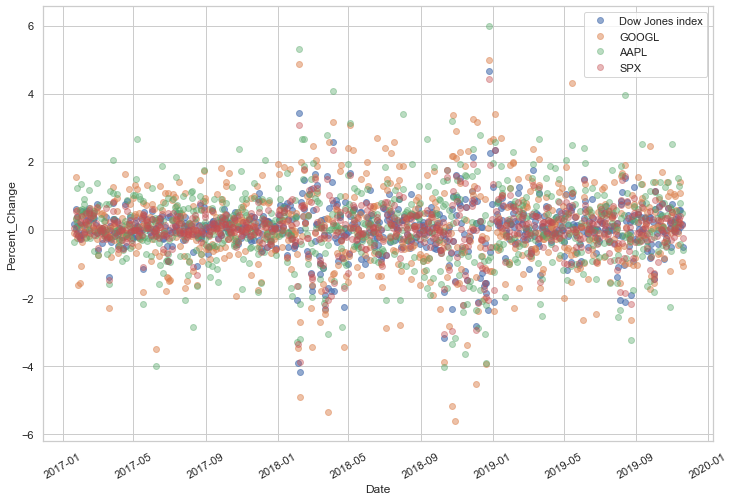

In [47]:
def ImportData(name = "^DJI",source='yahoo',start =datetime.date(2017,1,20), end = datetime.date(2019,11,18) ):
    '''
    This function takes a ticker symbol from a financial data source (yahoo as default), gathering
    daily data from a range start to end.
    
    #### input variables ####
    
        name: the ticker symbol of the stock/index

        source: financial database

        start: starting time of the stock data that the user requests

        end: ending time of the stock data that the user requests 
    
    #### output ####
    
        df: a data frame includes high,low,open,close,volume,adj close, percent_change
    
    ## Attributes ##
    
        high: highest price during the day

        low: lowest price during the day

        open: opening price at 9:30 am

        close: closing price at 4:00 pm

        volume: amount of trading that day

        adj close: I don't really know

        percent_change: (close-open)/open
        
        Rise (categorical): if percent_change > 0
        
        Date: the date

        Volatile (categorical): whether the stock experiences huge change on that day, (high-low)/((high+low)/2) > 5%
    
    '''

    df = web.DataReader(name,source,start,end)
    df['Percent_change'] = (df.Close-df.Open)/df.Open*100
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    
    #Change index name to avoid confusion
    df.index.name = "Index"
    
    #sort df according to Date
    df = df.sort_values('Date',ascending=False)

    ### Define the 'Rise' attribute ###
    rise_array = []
    volatile_array = []
    for i in range(len(df)):
        if df.iloc[i]['Percent_change']>0:
            rise_array.append(1)
        else:
            rise_array.append(0)
            
        if abs((df.iloc[i]['High']-df.iloc[i]['Low'])/((df.iloc[i]['High']+df.iloc[i]['Low'])/2))>0.01:
            volatile_array.append(1)
        else:
            volatile_array.append(0)
            
            
    df['Rise'] = rise_array
    df['Volatile'] = volatile_array
    return df

DJI_data = ImportData('^DJI','yahoo')
AAPL_data = ImportData('AAPL','yahoo')
GOOGL_data = ImportData('GOOGL','yahoo')
df_SPX = ImportData("^GSPC",'yahoo')

display(df_SPX.describe())

fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.plot(DJI_data.Date,DJI_data.Percent_change,'o',label = "Dow Jones index",alpha = 0.6)
ax.plot(GOOGL_data.Date,GOOGL_data.Percent_change,'o',label = 'GOOGL',alpha = 0.5)
ax.plot(AAPL_data.Date,AAPL_data.Percent_change,'o',label = 'AAPL',alpha = 0.4)
ax.plot(df_SPX.Date,df_SPX.Percent_change,'o',label = 'SPX',alpha = 0.4)
ax.set_xlabel("Date")
ax.set_ylabel("Percent_Change")
ax.legend()
plt.xticks(rotation = 30)
plt.show()


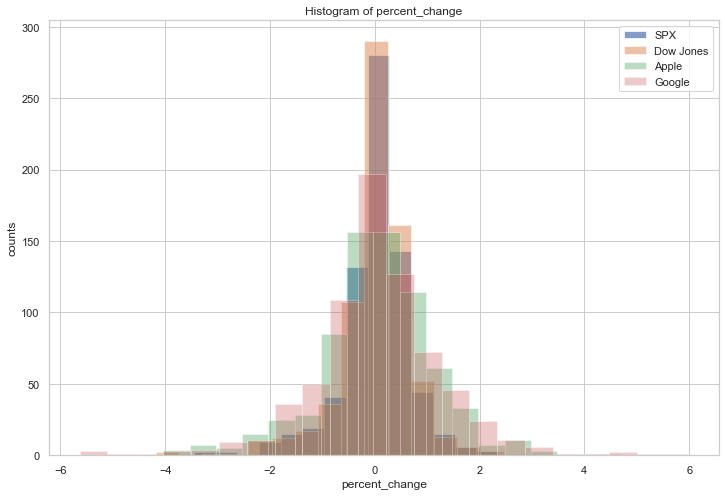

In [40]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(df_SPX.Percent_change,bins=20,label = 'SPX',alpha=0.7)
ax.hist(DJI_data.Percent_change,bins=20,label = 'Dow Jones',alpha=0.5)

ax.hist(AAPL_data.Percent_change,bins=20,label = 'Apple',alpha = 0.4)

ax.hist(GOOGL_data.Percent_change,bins=20,label = 'Google',alpha = 0.3)

ax.set_xlabel('percent_change')
ax.set_ylabel('counts')
ax.legend()
ax.set_title('Histogram of percent_change')
plt.show()

## Combine Tweet and Market Data into a Single Dataset

1. Create a column named trade_date_flag in tweet dataset to indicate whether the date is a trade-day or not

2. Create a combined dataset df_cbm based on df_SPX and add three columns:`trump_tweet_cnt`,`retweet_count`, and `favorite_count`, which indicate the number of tweets Trump tweeted, the number of retweets of Trump's tweets and the number of likes in a particular day



In [75]:
df_tweets_aggr['trade_date_flag'] = [1 if dt in df_SPX['Date'].values else 0 for dt in df_tweets_aggr['created_at']]

df_cbm = df_SPX.copy()
df_cbm['trump_tweet_cnt'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['trump_tweet_cnt'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['retweet_count'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['retweet_count'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['favorite_count'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['favorite_count'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['polarity'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['polarity'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['trade_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['trade_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['politics_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['politics_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['foreign_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['foreign_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]

display(df_cbm.head())
display(df_cbm.describe())

,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise,Volatile,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
Index,,,,,,,,,,,,,,,,,
2019-11-19,3127.639893,3113.469971,3127.449951,3120.179932,3590070000,3120.179932,-0.232458,2019-11-19,0,0,0,0.0,0.0,0.0,0,0,0
2019-11-18,3124.169922,3112.060059,3117.909912,3122.030029,3436690000,3122.030029,0.132144,2019-11-18,1,0,0,0.0,0.0,0.0,0,0,0
2019-11-15,3120.459961,3104.600098,3107.919922,3120.459961,3335650000,3120.459961,0.403487,2019-11-15,1,0,0,0.0,0.0,0.0,0,0,0
2019-11-14,3098.199951,3083.260010,3090.750000,3096.629883,3276070000,3096.629883,0.190241,2019-11-14,1,0,0,0.0,0.0,0.0,0,0,0
2019-11-13,3098.060059,3078.800049,3084.179932,3094.040039,3509280000,3094.040039,0.319699,2019-11-13,1,0,0,0.0,0.0,0.0,0,0,0


,High,Low,Open,Close,Volume,Adj Close,Percent_change,Rise,Volatile,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
count,714.000000,714.000000,714.000000,714.000000,7.140000e+02,714.000000,714.000000,714.000000,714.000000,714.00000,714.000000,7.140000e+02,714.000000,714.000000,714.000000,714.000000
mean,2703.280097,2679.821904,2692.149145,2692.359538,3.526373e+09,2692.359538,0.010883,0.546218,0.266106,9.19888,210174.042017,7.809283e+05,5.441737,3.173669,1.511204,1.151261
std,208.661151,206.241855,207.532085,207.366852,5.891499e+08,207.366852,0.694201,0.498208,0.442230,6.10839,142147.795744,4.743904e+05,10.644840,8.625484,2.074493,2.367873
min,2271.780029,2257.020020,2267.780029,2265.199951,1.349780e+09,2265.199951,-3.873729,0.000000,0.000000,0.00000,0.000000,0.000000e+00,-43.300000,0.000000,0.000000,0.000000
25%,2509.337463,2495.317566,2501.407532,2506.699951,3.199362e+09,2506.699951,-0.221172,0.000000,0.000000,5.00000,105484.500000,4.347775e+05,-0.275000,0.000000,0.000000,0.000000
50%,2733.034912,2703.029907,2718.645020,2719.250000,3.448825e+09,2719.250000,0.045254,1.000000,0.000000,8.00000,191104.000000,7.093275e+05,3.800000,0.000000,1.000000,0.000000
75%,2872.892456,2850.987610,2858.637451,2859.260010,3.772742e+09,2859.260010,0.343178,1.000000,1.000000,13.00000,281526.500000,1.072397e+06,11.275000,2.000000,2.000000,1.000000
max,3127.639893,3113.469971,3127.449951,3122.030029,7.609010e+09,3122.030029,4.425498,1.000000,1.000000,36.00000,789785.000000,2.639593e+06,59.600000,119.000000,15.000000,26.000000


# EDA and Baseline Model

1. We first perform a scatter plot on all the columns of the combined data frame. At first glance, `high`,`low`,`open`,`close`and `adj close` have some linear relationship with `trump_tweet_cnt`,`retweet_count`, and `favorite_count`. Other columns that are not directly reflecting the price, such as `volume` and `percent_change` seem to be unrelated to `trump_tweet_cnt`,`retweet_count`, or `favorite_count`. 


2. Therefore, we performed a simple linear regression model using `trump_tweet_cnt`, `retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculated the score. The score for the training set is 0.310 and the score for the test set is 0.340. These are pretty bad scores, so we will further process the data and then do the fitting. Lasso regularization can be implemented in the future, too.


3. Then we perform a series of k-NN model using `trump_tweet_cnt`,`retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculate the score. The best scores we get is when number of neighbors is 20. The training set_score is  0.350. The test set score is 0.346.

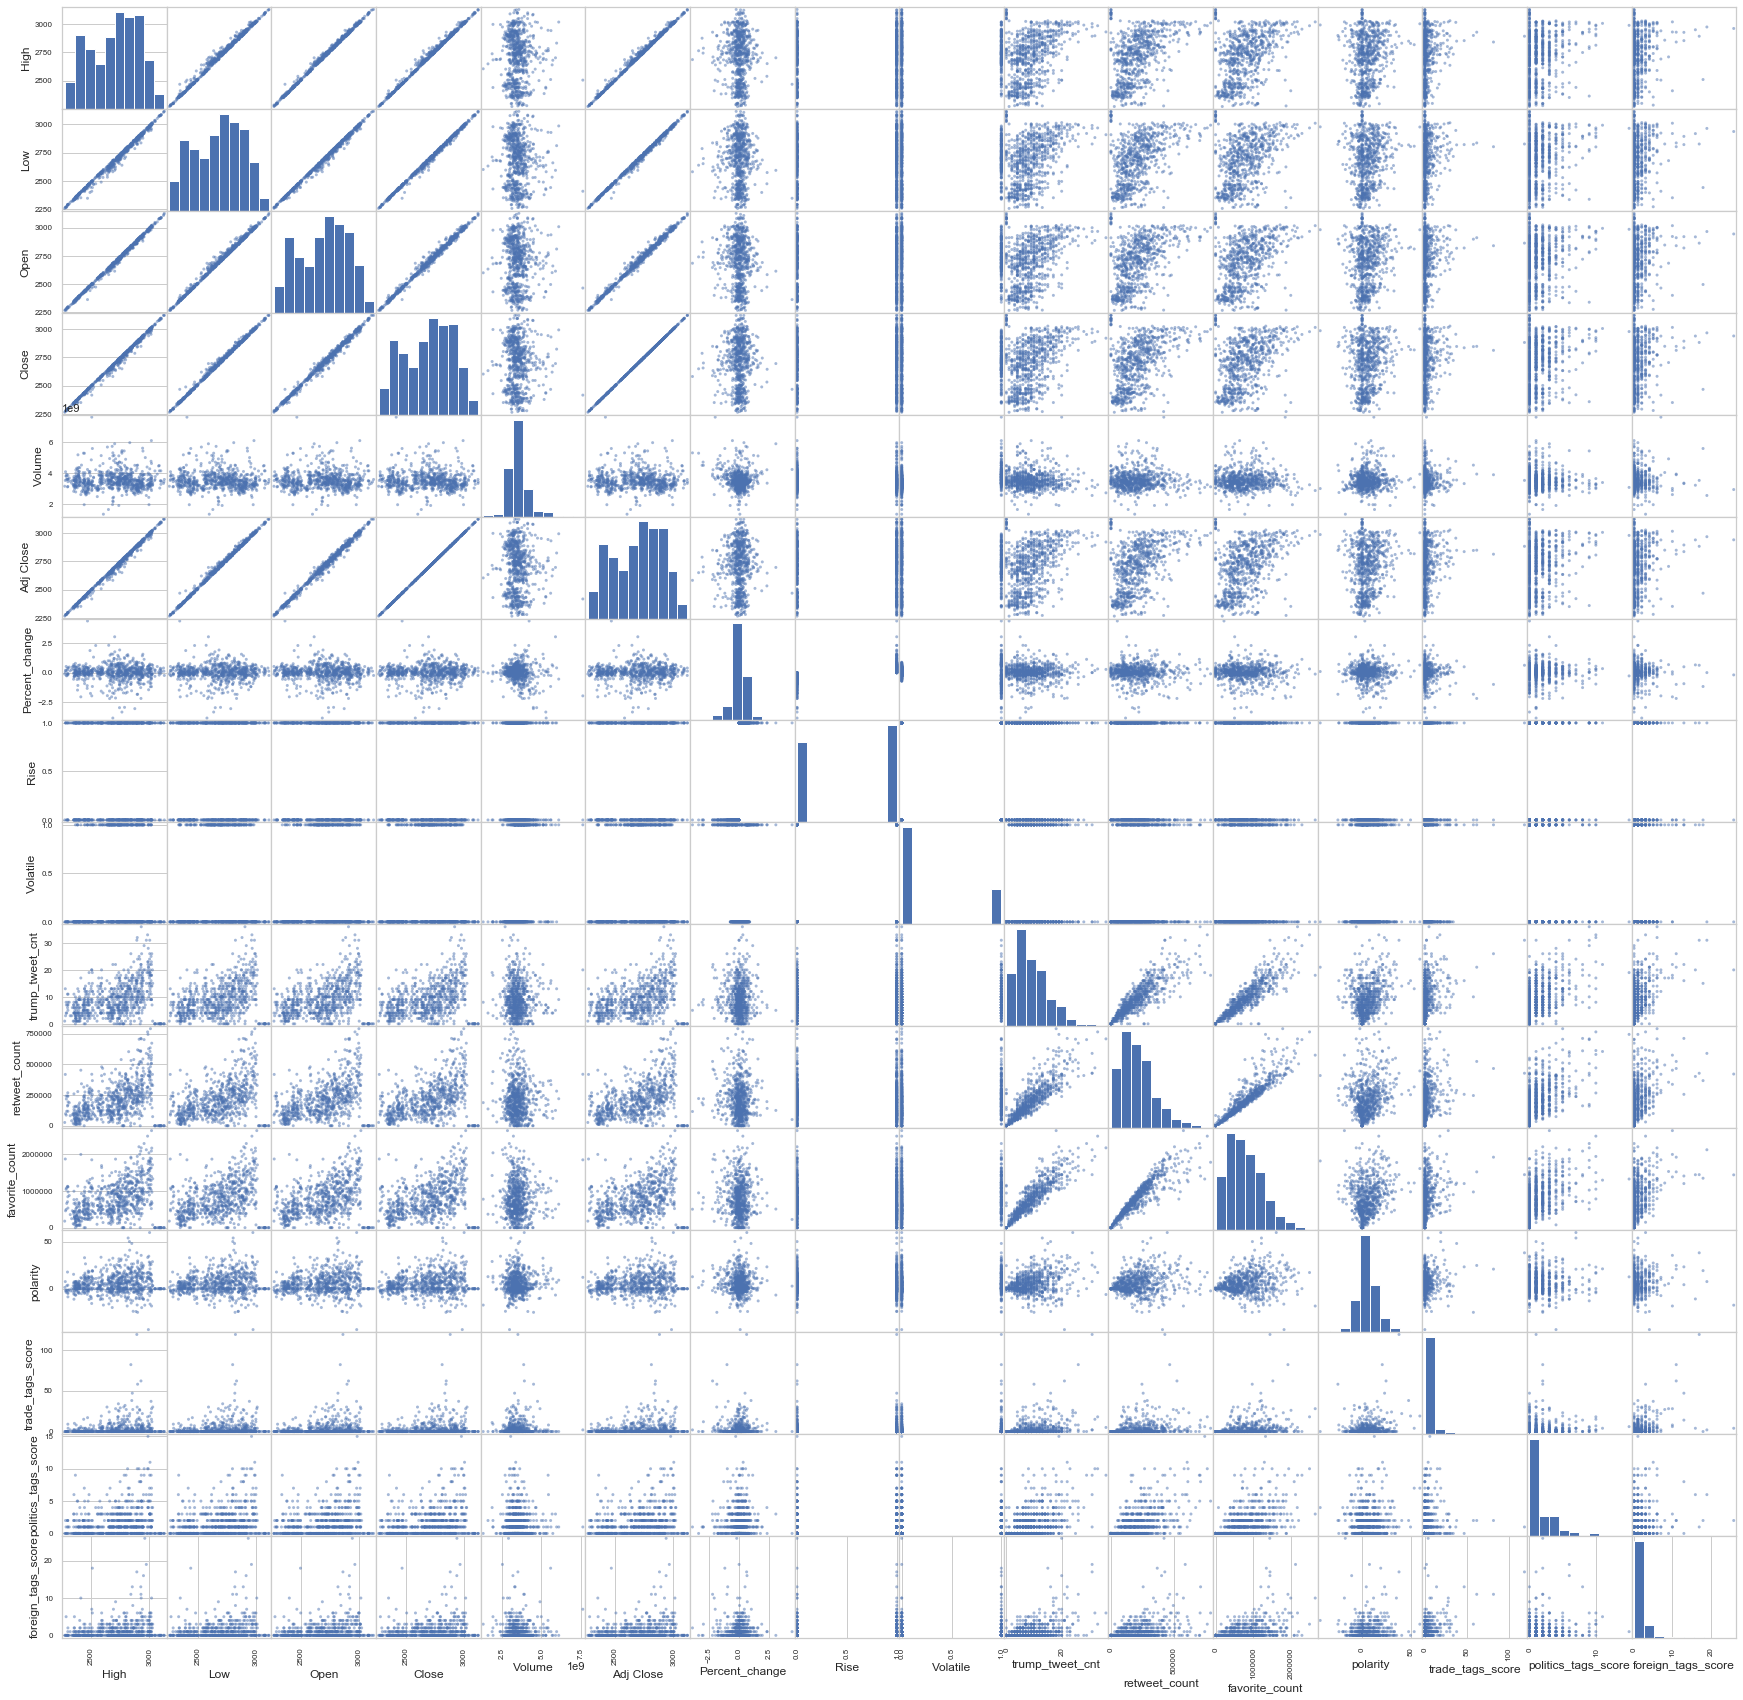

In [51]:
scatter_matrix(df_cbm,figsize=(30,30))
plt.savefig('./scatter_pair.png')
plt.show()

In [52]:
combined_df = pd.merge(left=df_tweets_aggr, right=df_SPX, how='left', left_on='created_at', right_on='Date')
combined_df.head()

,created_at,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score,trade_date_flag,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise,Volatile
0,2017-01-20,13,0,417567.0,1867501.0,7.6,0,0,0,1,2276.959961,2265.010010,2269.959961,2271.310059,3.524970e+09,2271.310059,0.059477,2017-01-20,1.0,0.0
1,2017-01-21,2,1,103818.0,467521.0,5.3,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-22,4,0,184236.0,949408.0,6.6,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-23,1,0,26750.0,177839.0,1.4,0,0,0,1,2271.780029,2257.020020,2267.780029,2265.199951,3.152710e+09,2265.199951,-0.113771,2017-01-23,0.0,0.0
4,2017-01-24,4,0,86707.0,495813.0,-1.2,0,0,0,1,2284.629883,2266.679932,2267.879883,2280.070068,3.810960e+09,2280.070068,0.537515,2017-01-24,1.0,0.0


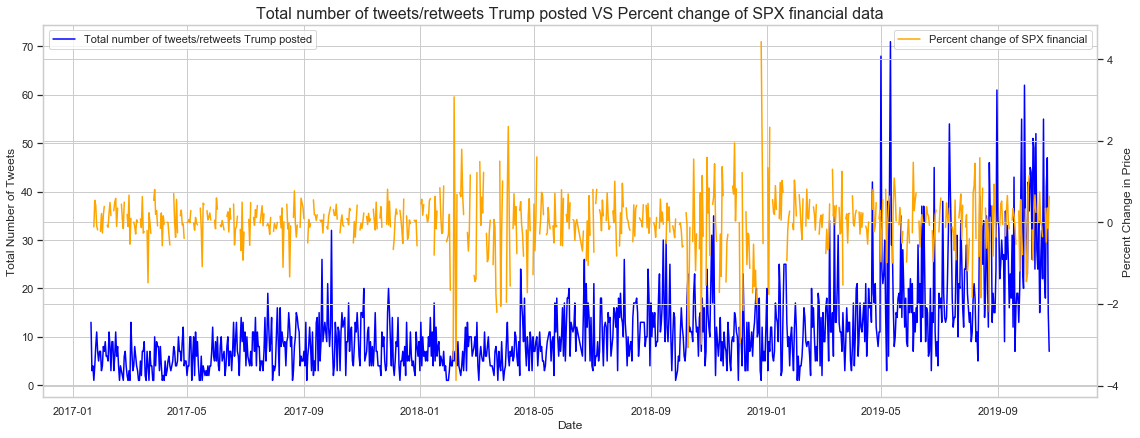

In [53]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(combined_df['created_at'],combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], color='blue', label='Total number of tweets/retweets Trump posted')
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Number of Tweets")
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel("Percent Change in Price")
ax2.plot(combined_df['created_at'], combined_df['Percent_change'], color='orange', label='Percent change of SPX financial')
fig.tight_layout() 

plt.title('Total number of tweets/retweets Trump posted VS Percent change of SPX financial data', fontsize=16)
plt.legend()
plt.show()

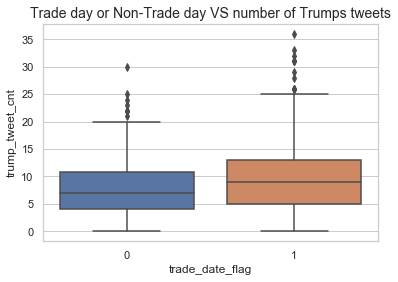

In [56]:
sns.boxplot(x = 'trade_date_flag', y = 'trump_tweet_cnt', data = combined_df)
plt.title('Trade day or Non-Trade day VS number of Trumps tweets', fontsize=14)
plt.show()

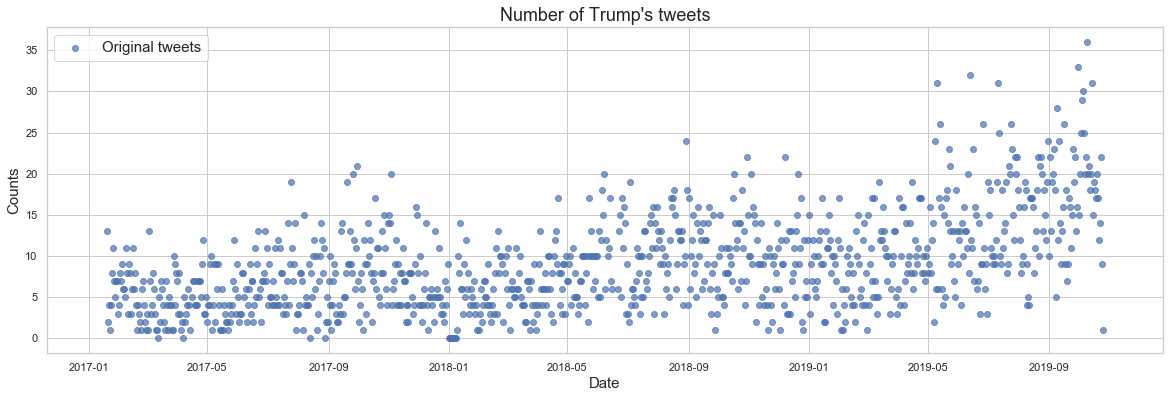

In [57]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['trump_tweet_cnt'], color='b',alpha=0.7, label='Original tweets')
#ax.scatter(combined_df['created_at'], combined_df['trump_retweet_cnt'], color='r', alpha=0.7, label='Retweets by Trump')
#ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color = 'orange', label = 'Retweets from Trump')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Number of Trump\'s tweets', fontsize=18)
plt.legend(fontsize = 15)
plt.show()

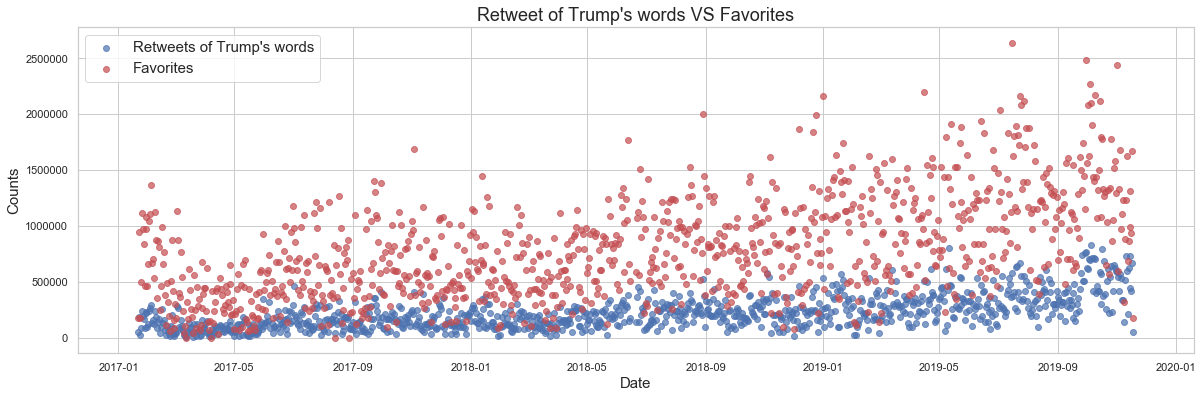

In [87]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color='b',alpha=0.7, label='Retweets of Trump\'s words')
ax.scatter(combined_df['created_at'], combined_df['favorite_count'], color='r', alpha=0.7, label='Favorites')
#ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color = 'orange', label = 'Retweets from Trump')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Retweet of Trump\'s words VS Favorites', fontsize=18)
plt.legend(fontsize = 15)
plt.savefig('/Users/YuhanZhang/Desktop/tweet_2.png')
plt.show()

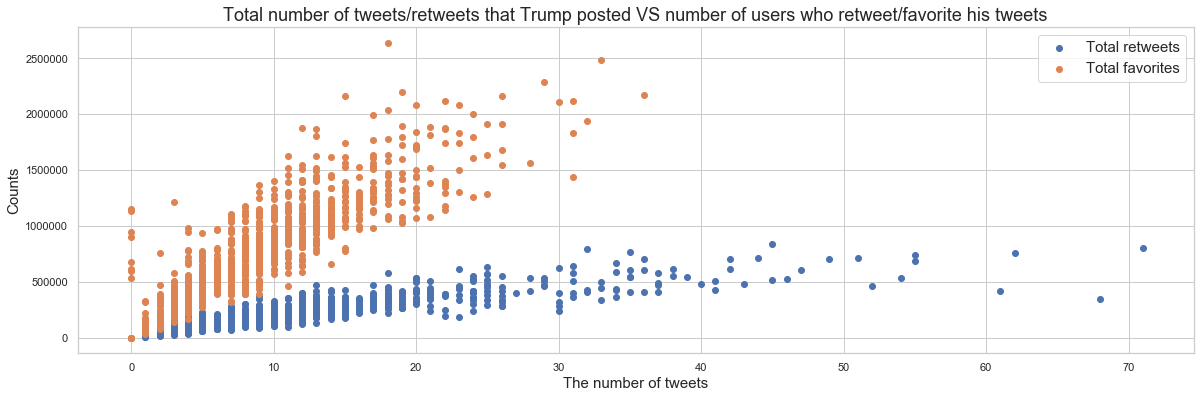

In [58]:
# used in the result analysis part
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], combined_df['retweet_count'], label="Total retweets")
ax.scatter(combined_df['trump_tweet_cnt'], combined_df['favorite_count'], label="Total favorites")
ax.set_xlabel("The number of tweets",fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15)
plt.title('Total number of tweets/retweets that Trump posted VS number of users who retweet/favorite his tweets', fontsize=18)
plt.legend(fontsize = 15)
plt.show()

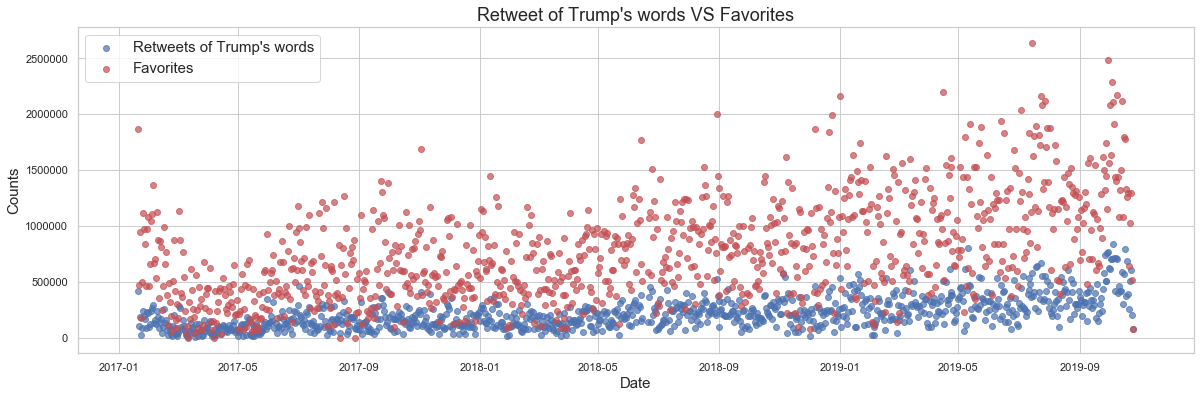

In [59]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color='b',alpha=0.7, label='Retweets of Trump\'s words')
ax.scatter(combined_df['created_at'], combined_df['favorite_count'], color='r', alpha=0.7, label='Favorites')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Retweet of Trump\'s words VS Favorites', fontsize=18)
plt.legend(fontsize = 15)
#plt.savefig('/Users/YuhanZhang/Desktop/tweet_2.png')
plt.show()

## Basic modelling

In [118]:


#df_cbm = df_cbm.iloc[17:] #only run once to drop the row of zeros

display(df_cbm.head())

x = df_cbm[['trump_tweet_cnt','retweet_count','favorite_count','polarity','trade_tags_score','politics_tags_score','foreign_tags_score']]

y = df_cbm['High']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

reg = LinearRegression().fit(X_train,y_train)
train_score = reg.score(X_train,y_train)
test_score = reg.score(X_test,y_test)
print("The training set_score is ",train_score,". The test set score is",test_score)

display(X_train.head())

,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise,Volatile,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
Index,,,,,,,,,,,,,,,,,
2019-10-25,3027.389893,3001.939941,3003.320068,3022.550049,3370370000,3022.550049,0.640291,2019-10-25,1,0,1,74119.0,76475.0,3.1,0,4,0
2019-10-24,3016.070068,3000.419922,3014.780029,3010.290039,3692600000,3010.290039,-0.148933,2019-10-24,0,0,9,203529.0,518594.0,1.6,0,1,3
2019-10-23,3004.780029,2991.209961,2994.010010,3004.520020,3392870000,3004.520020,0.351035,2019-10-23,1,0,22,604261.0,1292485.0,21.1,4,11,5
2019-10-22,3014.570068,2995.040039,3010.729980,2995.989990,3523890000,2995.989990,-0.489582,2019-10-22,0,0,14,504930.0,1022161.0,-1.2,2,9,3
2019-10-21,3007.330078,2995.350098,2996.479980,3006.719971,3271620000,3006.719971,0.341734,2019-10-21,1,0,12,251644.0,645387.0,10.9,0,2,0


The training set_score is  0.3055479428994057 . The test set score is 0.2621202224564284


,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
Index,,,,,,,
2019-07-01,19,308622.0,1472199.0,12.0,0,0,4
2019-08-14,17,384068.0,1231423.0,16.3,30,1,4
2018-12-11,13,266889.0,1165368.0,13.8,2,2,1
2017-08-08,4,125388.0,380389.0,-7.9,0,1,2
2018-01-10,10,188835.0,821099.0,6.0,0,2,0


### Normalize Data

In [119]:
from sklearn import preprocessing

# fit the scaler on the X_train
scaler = preprocessing.MinMaxScaler().fit(X_train)

# Scale X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Making the numpy scaled matrices pandas dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled_df.head()

,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
Index,,,,,,,
2019-07-01,0.527778,0.404198,0.557737,0.537415,0.000000,0.000000,0.153846
2019-08-14,0.472222,0.503008,0.466520,0.579203,0.252101,0.066667,0.153846
2018-12-11,0.361111,0.349541,0.441495,0.554908,0.016807,0.133333,0.038462
2017-08-08,0.111111,0.164219,0.144109,0.344023,0.000000,0.066667,0.076923
2018-01-10,0.277778,0.247314,0.311070,0.479106,0.000000,0.133333,0.000000


#### Update model with normalized data

In [120]:
reg_scaled = LinearRegression().fit(X_train_scaled_df,y_train)
train_score_scaled = reg.score(X_train_scaled_df,y_train)
test_score_scaled = reg.score(X_test_scaled_df,y_test)
print("The training set score is ",train_score_scaled,". The test set score is",test_score_scaled)

The training set score is  -0.669889434957553 . The test set score is -0.9702022784633095


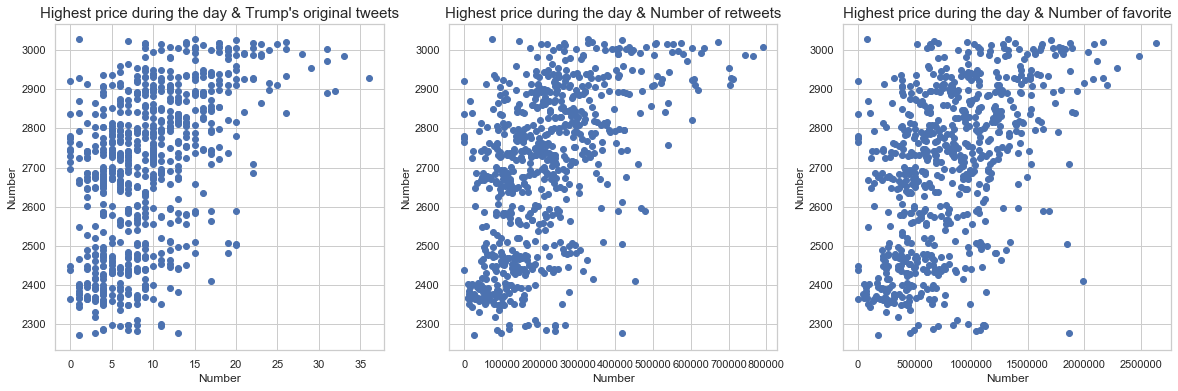

In [87]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
predictor = list(['trump_tweet_cnt','retweet_count','favorite_count'])
name = ['Trump\'s original tweets', 'Number of retweets', 'Number of favorite']
for i, item in enumerate(predictor):
    ax[i].scatter(df_cbm[item], y)
    ax[i].set_title('Highest price during the day & {}'.format(name[i]), fontsize = 15)
    ax[i].set_xlabel('Number')
    ax[i].set_ylabel('Number')



In [121]:
k_list = [1,2,3,5,6,7,8,10,20,25]
for k in k_list:
    kNN = KNeighborsRegressor(n_neighbors = k).fit(X_train,y_train)

    train_score = kNN.score(X_train,y_train)
    test_score = kNN.score(X_test,y_test)

    print("The number of neighbors is",k,"The training set_score is ",train_score,". The test set score is",test_score)

The number of neighbors is 1 The training set_score is  0.9867709397706813 . The test set score is -0.423347016620073
The number of neighbors is 2 The training set_score is  0.7023025553252018 . The test set score is 0.030451099410673917
The number of neighbors is 3 The training set_score is  0.5885100128545917 . The test set score is 0.15291238659357276
The number of neighbors is 5 The training set_score is  0.474554773512725 . The test set score is 0.20218153304656494
The number of neighbors is 6 The training set_score is  0.4551624558756089 . The test set score is 0.23168312467101237
The number of neighbors is 7 The training set_score is  0.4411205824111237 . The test set score is 0.2412945126522704
The number of neighbors is 8 The training set_score is  0.4183815227032589 . The test set score is 0.2567931752506959
The number of neighbors is 10 The training set_score is  0.3852110585550283 . The test set score is 0.253274077099936
The number of neighbors is 20 The training set_score

# Tree Model Fitting



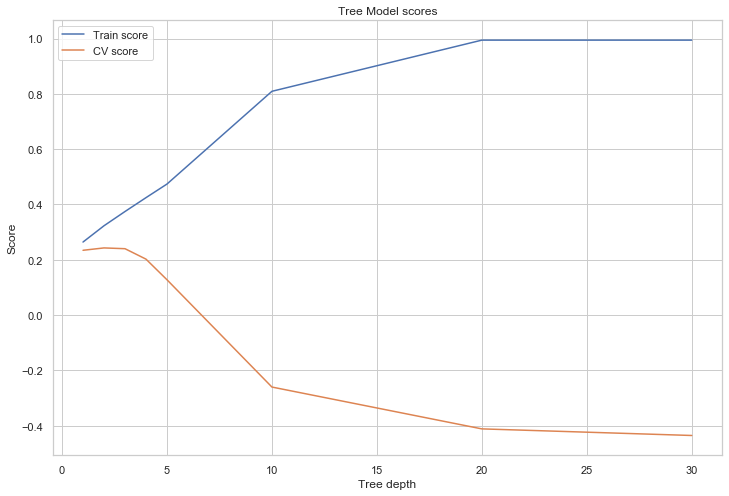

In [134]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score

max_depth = [1,2,3,4,5,10,20,30]
tree_models = []
tree_train_score = []
tree_cross_score = []
for depth in max_depth:
    
    dtree = DecisionTreeRegressor(max_depth=depth)
    dtree.fit(X_train,y_train)
    train_score = dtree.score(X_train,y_train)
    cross_scores = np.mean(cross_val_score(dtree,X_train,y_train,cv=5))
    tree_models.append(dtree)
    tree_train_score.append(train_score)
    tree_cross_score.append(cross_scores)

plt.figure(figsize=(12,8))
plt.plot(max_depth,tree_train_score,label='Train score')
plt.plot(max_depth,tree_cross_score,label='CV score')
plt.xlabel("Tree depth")
plt.ylabel("Score")
plt.title("Tree Model scores")
plt.legend()
plt.show()


### ANN



In [137]:
import tensorflow as tf


In [143]:
input_dimension = X_train.shape[1]
output_dimension = 1
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100,input_dim = input_dimension,kernel_initializer = 'normal'),
    tf.keras.layers.Dense(150,activation = 'relu'),
    tf.keras.layers.Dense(15,activation = 'relu'),
    tf.keras.layers.Dense(20,activation = 'relu'),
    tf.keras.layers.Dense(100,activation = 'relu'),

    tf.keras.layers.Dense(output_dimension,activation = 'linear'),

])

model.compile(optimizer = 'adam',loss='mean_absolute_error')
model.summary()

history = model.fit(X_train,y_train,validation_split=0.2,epochs=500,batch_size=32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               800       
_________________________________________________________________
dense_17 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_18 (Dense)             (None, 15)                2265      
_________________________________________________________________
dense_19 (Dense)             (None, 20)                320       
_________________________________________________________________
dense_20 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 20,736
Trainable params: 20,736
Non-trainable params: 0
__________________________________________________

445/445 [==============================] - 0s 56us/sample - loss: 1138.6075 - val_loss: 1097.6771
Epoch 63/500
445/445 [==============================] - 0s 63us/sample - loss: 1103.9625 - val_loss: 1092.3480
Epoch 64/500
445/445 [==============================] - 0s 66us/sample - loss: 1119.9732 - val_loss: 1116.9433
Epoch 65/500
445/445 [==============================] - 0s 55us/sample - loss: 1159.4171 - val_loss: 1087.1166
Epoch 66/500
445/445 [==============================] - 0s 62us/sample - loss: 1164.5301 - val_loss: 1133.6622
Epoch 67/500
445/445 [==============================] - 0s 53us/sample - loss: 1132.5790 - val_loss: 1100.3600
Epoch 68/500
445/445 [==============================] - 0s 63us/sample - loss: 1101.7250 - val_loss: 1075.7188
Epoch 69/500
445/445 [==============================] - 0s 58us/sample - loss: 1134.3750 - val_loss: 1172.8142
Epoch 70/500
445/445 [==============================] - 0s 61us/sample - loss: 1162.3200 - val_loss: 1155.8353
Epoch 71/500
4

445/445 [==============================] - 0s 50us/sample - loss: 1085.9657 - val_loss: 1109.6738
Epoch 136/500
445/445 [==============================] - 0s 57us/sample - loss: 1093.3419 - val_loss: 1122.9101
Epoch 137/500
445/445 [==============================] - 0s 53us/sample - loss: 1075.3909 - val_loss: 1091.0426
Epoch 138/500
445/445 [==============================] - 0s 57us/sample - loss: 1058.5687 - val_loss: 1060.6619
Epoch 139/500
445/445 [==============================] - 0s 50us/sample - loss: 1061.4500 - val_loss: 1063.9349
Epoch 140/500
445/445 [==============================] - 0s 56us/sample - loss: 1139.4607 - val_loss: 1039.1776
Epoch 141/500
445/445 [==============================] - 0s 55us/sample - loss: 1185.9266 - val_loss: 1097.3623
Epoch 142/500
445/445 [==============================] - 0s 61us/sample - loss: 1081.5340 - val_loss: 1056.2723
Epoch 143/500
445/445 [==============================] - 0s 59us/sample - loss: 1060.4296 - val_loss: 1080.9924
Epoch 

445/445 [==============================] - 0s 56us/sample - loss: 1074.9993 - val_loss: 1081.4446
Epoch 209/500
445/445 [==============================] - 0s 53us/sample - loss: 1064.5904 - val_loss: 1066.8895
Epoch 210/500
445/445 [==============================] - 0s 56us/sample - loss: 1095.5746 - val_loss: 1141.2978
Epoch 211/500
445/445 [==============================] - 0s 64us/sample - loss: 1096.1959 - val_loss: 1087.6193
Epoch 212/500
445/445 [==============================] - 0s 90us/sample - loss: 1062.3498 - val_loss: 1037.1401
Epoch 213/500
445/445 [==============================] - 0s 94us/sample - loss: 1075.3682 - val_loss: 1024.9549
Epoch 214/500
445/445 [==============================] - 0s 88us/sample - loss: 1058.0634 - val_loss: 1071.2408
Epoch 215/500
445/445 [==============================] - 0s 92us/sample - loss: 1064.9894 - val_loss: 1062.7092
Epoch 216/500
445/445 [==============================] - 0s 98us/sample - loss: 1107.2969 - val_loss: 1167.3164
Epoch 

Epoch 281/500
445/445 [==============================] - 0s 73us/sample - loss: 1121.3519 - val_loss: 1026.3813
Epoch 282/500
445/445 [==============================] - 0s 66us/sample - loss: 1061.8830 - val_loss: 1062.6090
Epoch 283/500
445/445 [==============================] - 0s 63us/sample - loss: 1070.1650 - val_loss: 1132.0348
Epoch 284/500
445/445 [==============================] - 0s 65us/sample - loss: 1084.3820 - val_loss: 1063.7561
Epoch 285/500
445/445 [==============================] - 0s 58us/sample - loss: 1056.3836 - val_loss: 1098.7143
Epoch 286/500
445/445 [==============================] - 0s 59us/sample - loss: 1064.9012 - val_loss: 1029.6905
Epoch 287/500
445/445 [==============================] - 0s 60us/sample - loss: 1072.4999 - val_loss: 1034.3051
Epoch 288/500
445/445 [==============================] - 0s 56us/sample - loss: 1096.5693 - val_loss: 1071.4611
Epoch 289/500
445/445 [==============================] - 0s 60us/sample - loss: 1063.7324 - val_loss: 10

445/445 [==============================] - 0s 56us/sample - loss: 1066.1543 - val_loss: 1029.3615
Epoch 355/500
445/445 [==============================] - 0s 50us/sample - loss: 1056.2731 - val_loss: 1056.7206
Epoch 356/500
445/445 [==============================] - 0s 49us/sample - loss: 1046.7011 - val_loss: 1035.3372
Epoch 357/500
445/445 [==============================] - 0s 53us/sample - loss: 1042.9129 - val_loss: 1100.6533
Epoch 358/500
445/445 [==============================] - 0s 50us/sample - loss: 1058.5592 - val_loss: 1083.3636
Epoch 359/500
445/445 [==============================] - 0s 65us/sample - loss: 1054.1911 - val_loss: 1053.6931
Epoch 360/500
445/445 [==============================] - 0s 53us/sample - loss: 1058.2544 - val_loss: 1027.3473
Epoch 361/500
445/445 [==============================] - 0s 56us/sample - loss: 1051.8716 - val_loss: 1079.5407
Epoch 362/500
445/445 [==============================] - 0s 56us/sample - loss: 1048.4569 - val_loss: 1071.1571
Epoch 

445/445 [==============================] - 0s 53us/sample - loss: 1056.2461 - val_loss: 1097.8139
Epoch 428/500
445/445 [==============================] - 0s 48us/sample - loss: 1048.5145 - val_loss: 1096.5945
Epoch 429/500
445/445 [==============================] - 0s 55us/sample - loss: 1039.2490 - val_loss: 1004.9858
Epoch 430/500
445/445 [==============================] - 0s 51us/sample - loss: 1050.2624 - val_loss: 1067.2018
Epoch 431/500
445/445 [==============================] - 0s 53us/sample - loss: 1063.2790 - val_loss: 1027.3636
Epoch 432/500
445/445 [==============================] - 0s 54us/sample - loss: 1035.0201 - val_loss: 1058.8507
Epoch 433/500
445/445 [==============================] - 0s 56us/sample - loss: 1043.7927 - val_loss: 1028.3732
Epoch 434/500
445/445 [==============================] - 0s 48us/sample - loss: 1049.5647 - val_loss: 1126.9345
Epoch 435/500
445/445 [==============================] - 0s 51us/sample - loss: 1089.7871 - val_loss: 1022.1575
Epoch 

445/445 [==============================] - 0s 51us/sample - loss: 1039.9294 - val_loss: 1045.8808


# Future Work

1. The baseline model clearly gives terrible fitting. The failure is due to the lack of proper predictors. The number of tweets by Trump does not mean much to the market; rather, it's the content in those tweets that matters more. A simple modification on the current dataset is to have a column named ave_retweet or ave_favorite, whose value is `retweet_count`/`trump_tweet_cnt` or `favorite_count`/`trump_tweet_cnt`. This column would reflect the importance of the tweets at a particular day. We expect important tweets have more influence on the market.

2. An important task to do is to categorize the tweets based on the content. Possible categories are, whether a tweet mentions market(e.g. mentions a company's name or an industry), whether a tweet mentions trade war, whether a tweet expresses positive or negative attitude, whether a tweet uses strong language or not. After categorization, we may use models such as decision tree to find out the most important features that influence the market.

3. We will find out the most frequent phrases that Trump uses in the tweets and check how the appearance of these phrases influence market behavior.

4. We can include more features into the market data. For example, we can have a column named big_change, indicating whether the stock/index experiences a change that is way larger than $2*std$. 


# Topic Modeling - Tweets text

## Theoretical Overview

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.    
    
We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:    
psi -- the distribution of words for each topic K    
phi -- the distribution of topics for each document i    

In [5]:
print('Total tweets', len(df_tweets))
df_tweets.head()

Total tweets 12333


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,https://t.co/Mqj5tXaDAz,11-18-2019 04:38:28,15115,41938,False,1196286528546332672
1,Twitter for iPhone,“All they do is bring up witnesses who didn’t ...,11-18-2019 03:39:38,16476,61998,False,1196271720392511489
2,Twitter for iPhone,“The Impeachment started before he even became...,11-18-2019 02:40:04,18488,75282,False,1196256729471827968
3,Twitter for iPhone,https://t.co/1Rg66Tn4uP,11-17-2019 22:57:43,16318,51690,False,1196200775560634368
4,Twitter for iPhone,https://t.co/D66PEkuX6d,11-17-2019 22:51:37,12209,38663,False,1196199239715639302


In [ ]:
def grep_ref_tweet_ids(text):
    ref_tweet_ids=[]
    ref_tweet_ids = re.findall(r'@(\w+)\W',text)
    #clean_text= re.sub(r'@(\w+)\W', r' ', text)
    return ref_tweet_ids, clean_text

In [ ]:
def grep_hash_tags(text):
    ref_hash_tags=[]
    ref_hash_tags = re.findall(r'#([\w]{3,})\W',text)
    clean_text= text #re.sub(r'#([\w]{3,})\W', r' ', text)
    return ref_hash_tags, clean_text

In [ ]:
def grep_ref_https_link(text):
    ref_http_links=[]
    ref_http_links=[]
    ref_http_links = re.findall(r'(https?://[\w\.\/]+)\W',text)
    clean_text=text
    return ref_http_links, clean_text

In [12]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [11]:
# Load the regular expression library
import re

# Remove punctuation
df_tweets['tweet_text_processed'] = df_tweets['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the tweets to lowercase
df_tweets['tweet_text_processed'] = df_tweets['tweet_text_processed'].map(lambda x: x.lower())

# Print out the few rows of tweets
df_tweets['tweet_text_processed'].head()

0                               https://tco/mqj5txadaz
1    “all they do is bring up witnesses who didn’t ...
2    “the impeachment started before he even became...
3                               https://tco/1rg66tn4up
4                               https://tco/d66pekux6d
Name: tweet_text_processed, dtype: object

### Exploratory Analysis - WordCloud

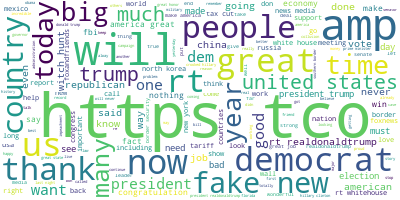

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed tweets together
long_string = ','.join(list(df_tweets['tweet_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Prepare text for LDA analysis

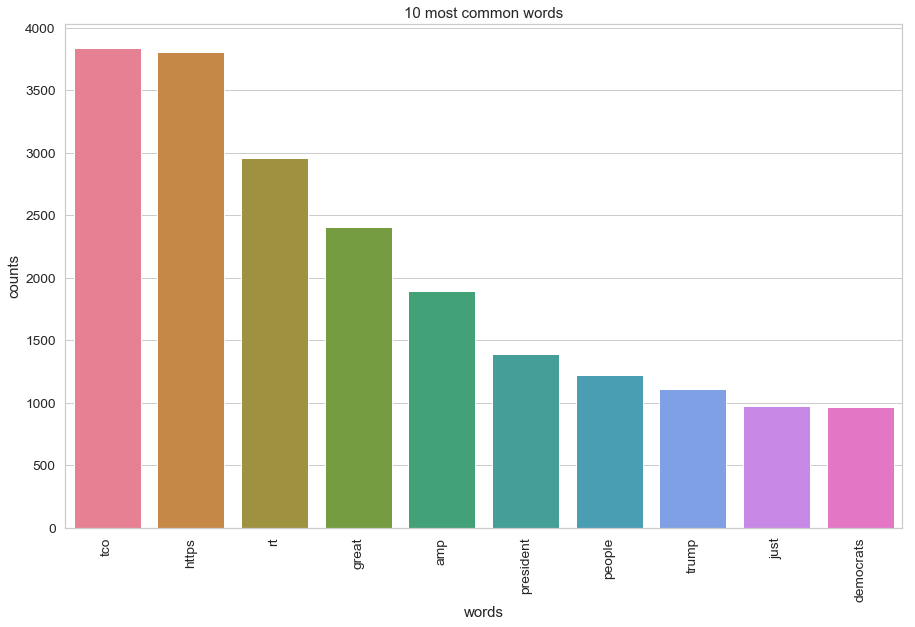

In [10]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed tweets
count_data = count_vectorizer.fit_transform(df_tweets['tweet_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### LDA model tranining

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
border democrats people amp wall want country security trump hillary

Topic #1:
rt tco https realdonaldtrump thank trump president amp america today

Topic #2:
news fake media rt amp trump democrats people just president

Topic #3:
great amp big china country trade vote president america years

Topic #4:
tco https rt great realdonaldtrump thank president today whitehouse american
